In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from datasets import Emotions_dataset, show_img_dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from models import Emotion_Models
from tqdm import tqdm
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch import optim
import time
import matplotlib.pyplot as plt

In [15]:
class Config:
    TRAIN_PATH = 'data\\train'
    TEST_PATH = 'data\\test'

    IMAGE_SIZE = 48
    BATCH_SIZE = 16
    WEIGHT_CLASSES = []
    CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
config = Config()
print(config.DEVICE)

cuda


In [17]:
transform = A.Compose([
    A.Resize(height=96, width=96),
    A.HorizontalFlip(p=0.6), 
    A.CoarseDropout(
        num_holes_range= (2, 7),
        p = 0.8
    ),
    A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255),
    ToTensorV2(), 
])


In [18]:
dataset_train = Emotions_dataset(PATH = config.TRAIN_PATH, transform= transform)
dataset_test = Emotions_dataset(PATH = config.TEST_PATH, transform= transform)

In [19]:
def sampler_init(dataset : Emotions_dataset):
    weight = [1/dataset.len_class[i[1]] for i in dataset.samples]
    sampler = WeightedRandomSampler(
        weights= weight,
        num_samples= len(dataset),
        replacement= True
    )
    return sampler

In [20]:
train_loader = DataLoader(
    dataset= dataset_train,
    batch_size= 64,
    sampler= sampler_init(dataset_train),
    pin_memory= True,
    drop_last= True,
    num_workers= 8,
    prefetch_factor= 4,
    persistent_workers=True

)


test_loader = DataLoader(
    dataset= dataset_test,
    batch_size=64,
    sampler=sampler_init(dataset_test),
    pin_memory= True,
    drop_last= False
)

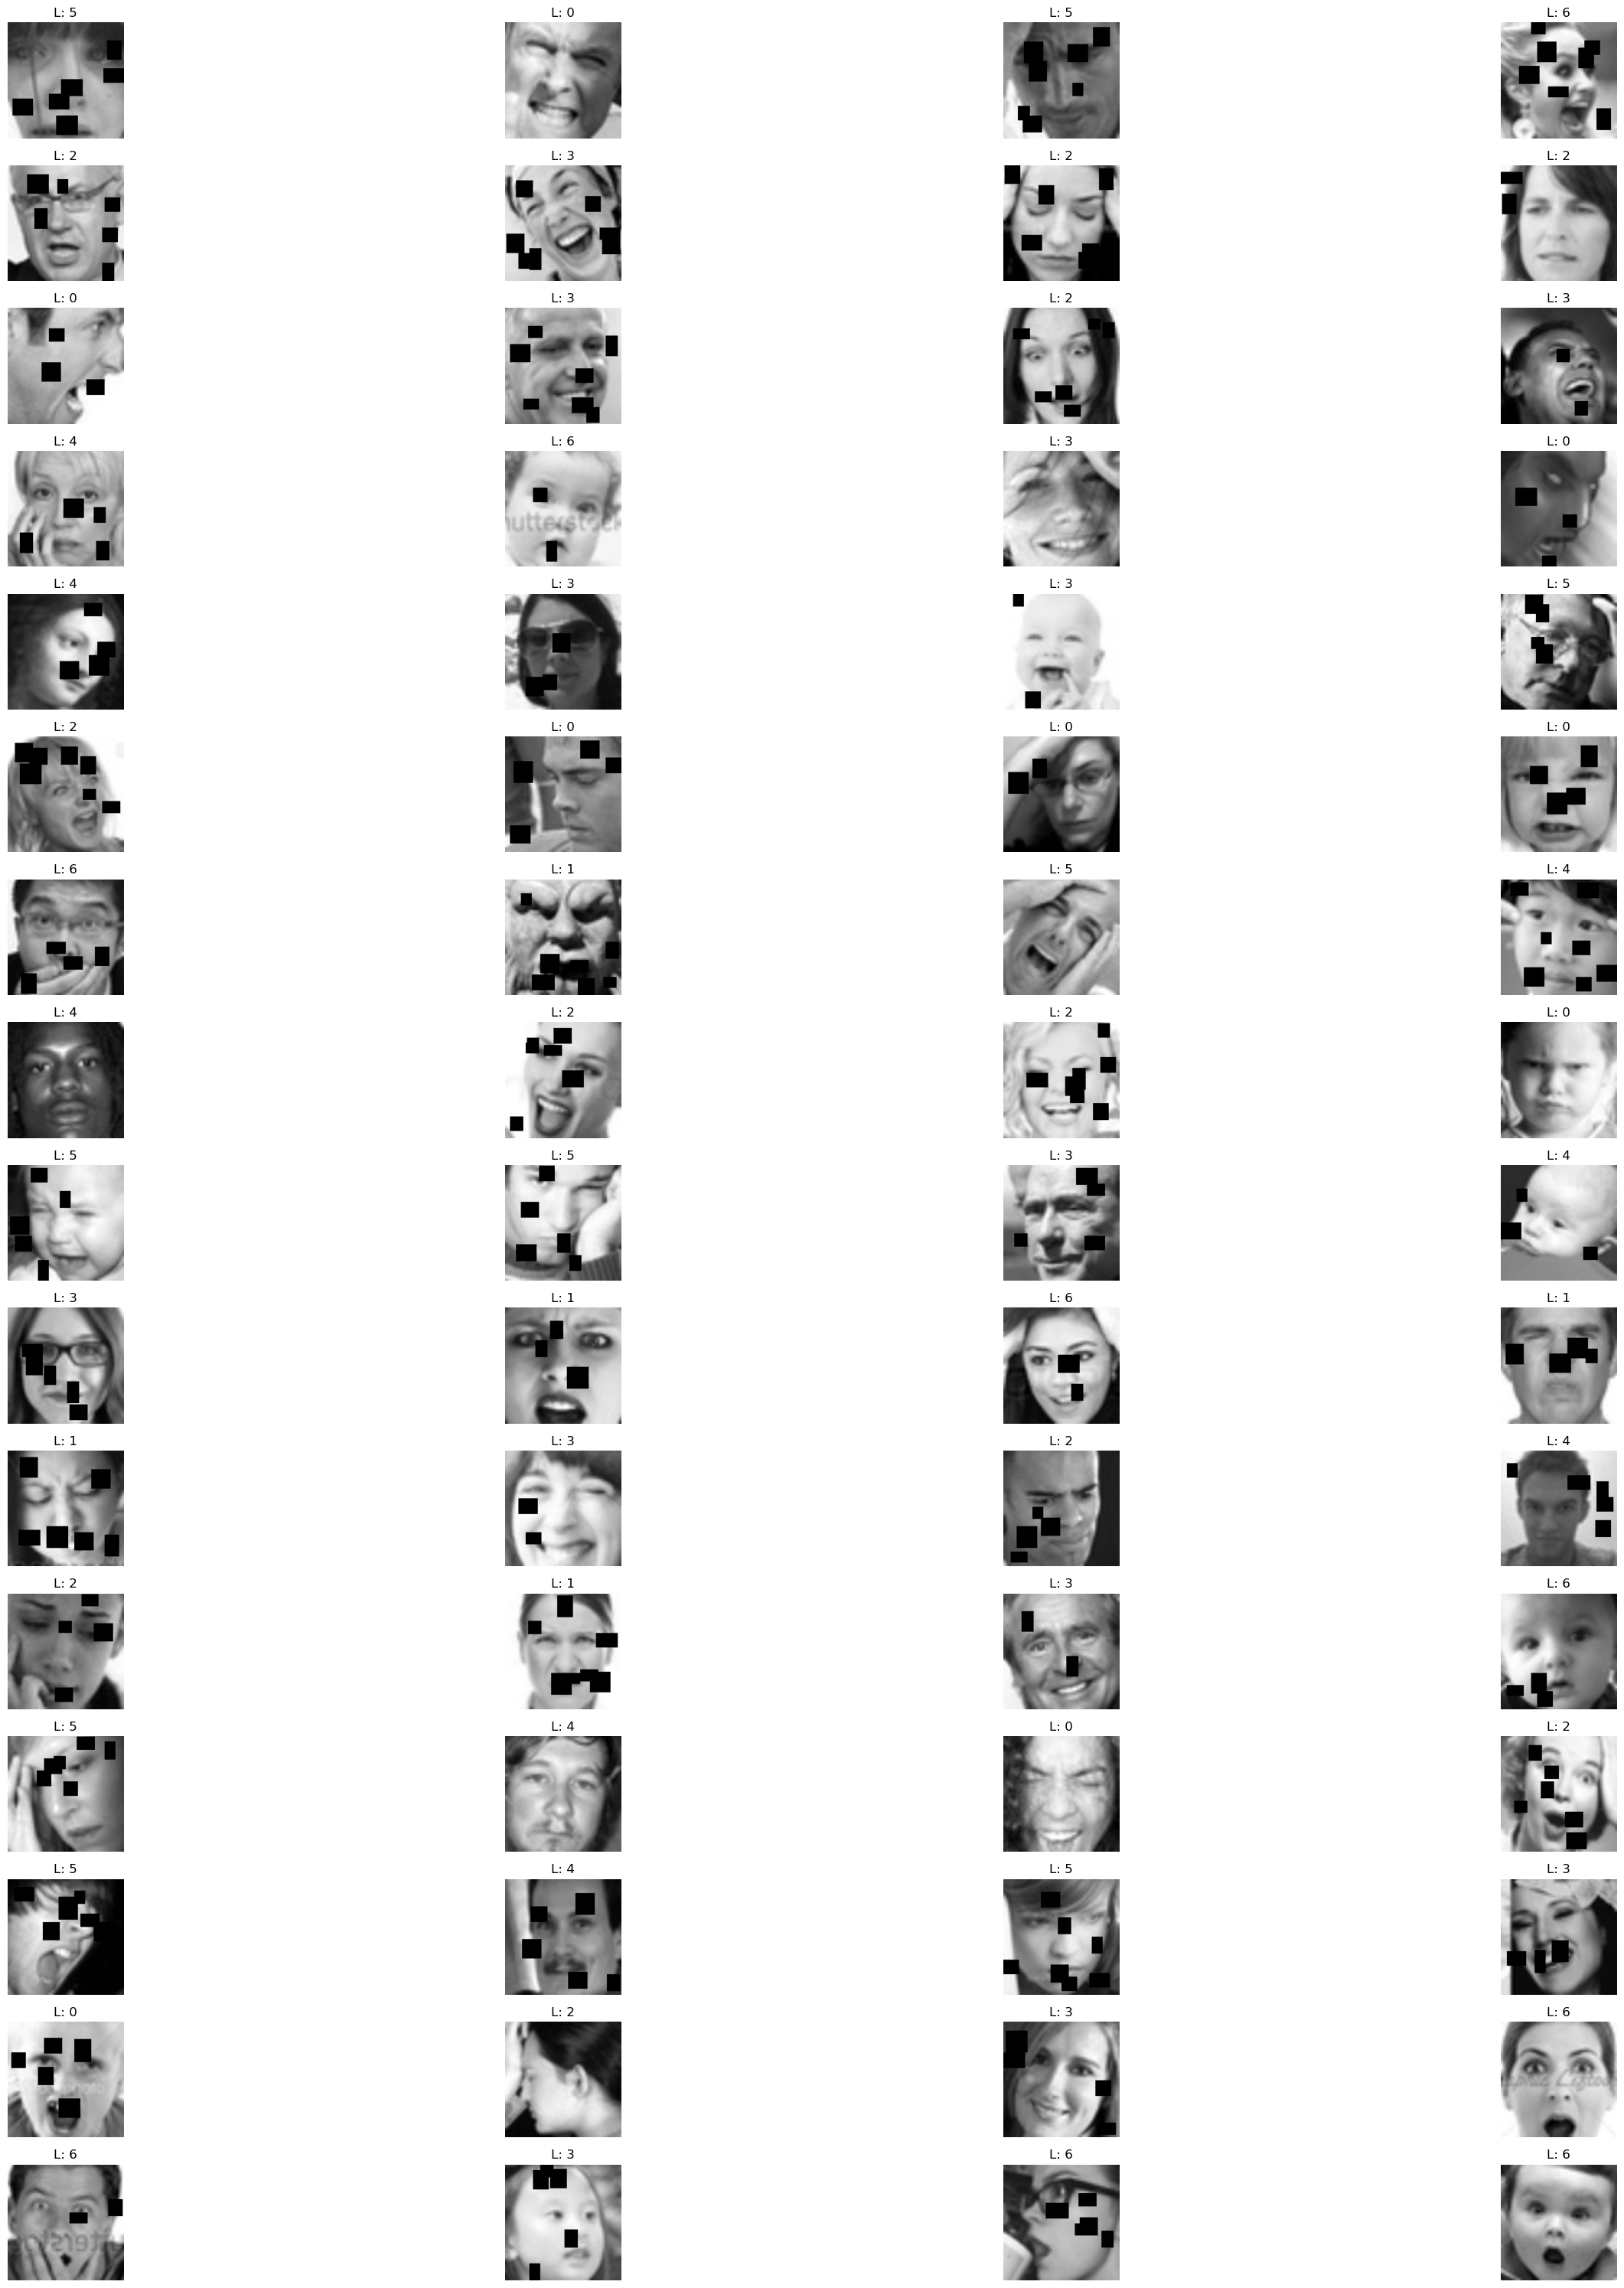

In [21]:
show_img_dataset(train_loader)

In [22]:
model = Emotion_Models(classes= 7)
# model.save_model()
model.load_model(device= config.DEVICE)
# model = model.to(config.DEVICE)

In [23]:
def evaluate(model, loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    accuracy = accuracy_score(all_labels, all_preds)

    return precision, recall, f1, accuracy


In [24]:
def training_models(device, model, train_loader, test_loader, num_epochs=50, compile_model=False):

    model = model.to(device)

    # Optional torch.compile (PyTorch 2.x)
    if compile_model and hasattr(torch, "compile"):
        model = torch.compile(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    use_amp = device.type == "cuda"
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'test_f1': []
    }

    best_f1 = 0.0

    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (inputs, labels) in enumerate(pbar):

            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast("cuda", enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Gradient clipping (ổn định)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()

            # Accumulate loss ở CPU (tránh giữ tensor GPU)
            running_loss += loss.detach().item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 50 == 0:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

        scheduler.step()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        precision, recall, f1, accuracy = evaluate(model, test_loader, device)

        print(
            f"\nEpoch {epoch+1} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {accuracy:.4f} | "
            f"F1: {f1:.4f} | "
            f"LR: {scheduler.get_last_lr()[0]:.6f}"
        )

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(accuracy)
        history['test_f1'].append(f1)

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), "best_model.pth")
            print("⭐ New Best Model Saved")

    return history

In [25]:
print(next(model.parameters()).device)

cpu


In [26]:
history = training_models(
    device= config.DEVICE, 
    model= model, 
    train_loader= train_loader, 
    test_loader= test_loader, 
    num_epochs=30
    )

Epoch 1/30: 100%|██████████| 448/448 [03:18<00:00,  2.26it/s, loss=1.8178]



Epoch 1 | Train Loss: 1.9302 | Train Acc: 0.1941 | Test Acc: 0.1911 | F1: 0.1543 | LR: 0.000997
⭐ New Best Model Saved


Epoch 2/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=1.7747]



Epoch 2 | Train Loss: 1.8516 | Train Acc: 0.2396 | Test Acc: 0.2685 | F1: 0.2346 | LR: 0.000989
⭐ New Best Model Saved


Epoch 3/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=1.5108]



Epoch 3 | Train Loss: 1.7036 | Train Acc: 0.3229 | Test Acc: 0.3272 | F1: 0.3094 | LR: 0.000976
⭐ New Best Model Saved


Epoch 4/30: 100%|██████████| 448/448 [03:17<00:00,  2.27it/s, loss=1.5556]



Epoch 4 | Train Loss: 1.5110 | Train Acc: 0.4189 | Test Acc: 0.3619 | F1: 0.3252 | LR: 0.000957
⭐ New Best Model Saved


Epoch 5/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=1.2881]



Epoch 5 | Train Loss: 1.3696 | Train Acc: 0.4802 | Test Acc: 0.4242 | F1: 0.4141 | LR: 0.000933
⭐ New Best Model Saved


Epoch 6/30: 100%|██████████| 448/448 [03:16<00:00,  2.28it/s, loss=1.4057]



Epoch 6 | Train Loss: 1.2478 | Train Acc: 0.5266 | Test Acc: 0.4440 | F1: 0.3993 | LR: 0.000905


Epoch 7/30: 100%|██████████| 448/448 [03:19<00:00,  2.24it/s, loss=0.9541]



Epoch 7 | Train Loss: 1.1724 | Train Acc: 0.5536 | Test Acc: 0.4432 | F1: 0.4583 | LR: 0.000872
⭐ New Best Model Saved


Epoch 8/30: 100%|██████████| 448/448 [03:15<00:00,  2.30it/s, loss=0.9451]



Epoch 8 | Train Loss: 1.0931 | Train Acc: 0.5822 | Test Acc: 0.4896 | F1: 0.4799 | LR: 0.000835
⭐ New Best Model Saved


Epoch 9/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=1.0787]



Epoch 9 | Train Loss: 1.0439 | Train Acc: 0.6042 | Test Acc: 0.4911 | F1: 0.4878 | LR: 0.000794
⭐ New Best Model Saved


Epoch 10/30: 100%|██████████| 448/448 [03:15<00:00,  2.30it/s, loss=0.9003]



Epoch 10 | Train Loss: 0.9909 | Train Acc: 0.6230 | Test Acc: 0.5160 | F1: 0.4889 | LR: 0.000750
⭐ New Best Model Saved


Epoch 11/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=1.0079]



Epoch 11 | Train Loss: 0.9364 | Train Acc: 0.6435 | Test Acc: 0.4483 | F1: 0.4307 | LR: 0.000703


Epoch 12/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.9056]



Epoch 12 | Train Loss: 0.9061 | Train Acc: 0.6566 | Test Acc: 0.5107 | F1: 0.5192 | LR: 0.000655
⭐ New Best Model Saved


Epoch 13/30: 100%|██████████| 448/448 [03:15<00:00,  2.30it/s, loss=0.8442]



Epoch 13 | Train Loss: 0.8579 | Train Acc: 0.6753 | Test Acc: 0.5596 | F1: 0.5313 | LR: 0.000604
⭐ New Best Model Saved


Epoch 14/30: 100%|██████████| 448/448 [03:15<00:00,  2.30it/s, loss=0.8460]



Epoch 14 | Train Loss: 0.8423 | Train Acc: 0.6828 | Test Acc: 0.5510 | F1: 0.5517 | LR: 0.000552
⭐ New Best Model Saved


Epoch 15/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.8216]



Epoch 15 | Train Loss: 0.8076 | Train Acc: 0.6951 | Test Acc: 0.5302 | F1: 0.5107 | LR: 0.000500


Epoch 16/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=0.9125]



Epoch 16 | Train Loss: 0.7609 | Train Acc: 0.7151 | Test Acc: 0.5864 | F1: 0.5824 | LR: 0.000448
⭐ New Best Model Saved


Epoch 17/30: 100%|██████████| 448/448 [03:15<00:00,  2.29it/s, loss=0.5963]



Epoch 17 | Train Loss: 0.7191 | Train Acc: 0.7324 | Test Acc: 0.5680 | F1: 0.5550 | LR: 0.000396


Epoch 18/30: 100%|██████████| 448/448 [03:15<00:00,  2.30it/s, loss=0.7851]



Epoch 18 | Train Loss: 0.6921 | Train Acc: 0.7404 | Test Acc: 0.5574 | F1: 0.5413 | LR: 0.000345


Epoch 19/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.5252]



Epoch 19 | Train Loss: 0.6501 | Train Acc: 0.7578 | Test Acc: 0.5607 | F1: 0.5611 | LR: 0.000297


Epoch 20/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.6238]



Epoch 20 | Train Loss: 0.6057 | Train Acc: 0.7759 | Test Acc: 0.5724 | F1: 0.5835 | LR: 0.000250
⭐ New Best Model Saved


Epoch 21/30: 100%|██████████| 448/448 [03:14<00:00,  2.31it/s, loss=0.5622]



Epoch 21 | Train Loss: 0.5600 | Train Acc: 0.7928 | Test Acc: 0.5851 | F1: 0.5888 | LR: 0.000206
⭐ New Best Model Saved


Epoch 22/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.7355]



Epoch 22 | Train Loss: 0.5383 | Train Acc: 0.8011 | Test Acc: 0.5862 | F1: 0.5918 | LR: 0.000165
⭐ New Best Model Saved


Epoch 23/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.5879]



Epoch 23 | Train Loss: 0.5159 | Train Acc: 0.8127 | Test Acc: 0.5993 | F1: 0.5960 | LR: 0.000128
⭐ New Best Model Saved


Epoch 24/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.4063]



Epoch 24 | Train Loss: 0.4662 | Train Acc: 0.8255 | Test Acc: 0.5949 | F1: 0.6036 | LR: 0.000095
⭐ New Best Model Saved


Epoch 25/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.3526]



Epoch 25 | Train Loss: 0.4578 | Train Acc: 0.8328 | Test Acc: 0.5933 | F1: 0.5996 | LR: 0.000067


Epoch 26/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.6040]



Epoch 26 | Train Loss: 0.4367 | Train Acc: 0.8424 | Test Acc: 0.6070 | F1: 0.6161 | LR: 0.000043
⭐ New Best Model Saved


Epoch 27/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.4120]



Epoch 27 | Train Loss: 0.4115 | Train Acc: 0.8495 | Test Acc: 0.5766 | F1: 0.5811 | LR: 0.000024


Epoch 28/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.3151]



Epoch 28 | Train Loss: 0.4081 | Train Acc: 0.8516 | Test Acc: 0.6091 | F1: 0.6153 | LR: 0.000011


Epoch 29/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.5177]



Epoch 29 | Train Loss: 0.4028 | Train Acc: 0.8548 | Test Acc: 0.5924 | F1: 0.6004 | LR: 0.000003


Epoch 30/30: 100%|██████████| 448/448 [03:14<00:00,  2.30it/s, loss=0.4417]



Epoch 30 | Train Loss: 0.4078 | Train Acc: 0.8506 | Test Acc: 0.5968 | F1: 0.6004 | LR: 0.000000


In [27]:
def plot_history(history):

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'])
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Accuracy + F1
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'])
    plt.plot(epochs, history['test_acc'])
    plt.plot(epochs, history['test_f1'])
    plt.title("Accuracy / F1")
    plt.xlabel("Epoch")
    plt.legend(["Train Acc", "Test Acc", "Test F1"])

    plt.tight_layout()
    plt.show()

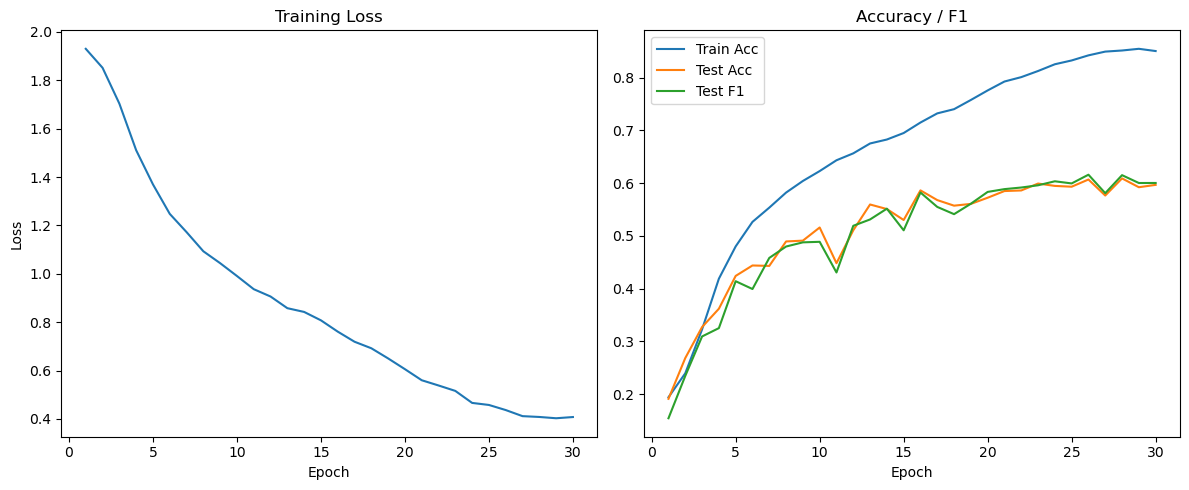

: 

In [ ]:
plot_history(history)